# Implementing Hyperbolic SVM
`Drew Wilimitis`

In this notebook, I attempt to implement another foundational supervised learning algorithm in hyperbolic space to continue exploring how hyperbolic embeddings can be integrated with downstream machine learning tasks in order to fully exploit the representational capacity of hyperbolic geometry. <br>
<br>
I follow the approach recently outlined in "Large-margin classification in hyperbolic space". Cho, H., Demeo, B., Peng, J., Berger, B. CoRR abs/1806.00437 (2018)

## Algorithm Outline

Given data in the Poincare disk $x_1, \ldots , x_N \in \mathcal{B}^{d}$, partition the $N$ observations into k sets denoted by $\mathbf{S}=\left\{S_{1}, S_{2}, \ldots, S_{k}\right\}$, where we have $k$ centroids or means $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k}$ at each iteration $t$. <br>
<br>
The basic steps in Hyperbolic k-means are: <br>
1. **Initialization step**: initialize k random centroids $\left\{\boldsymbol{m}_{i}^{(t)}\right\}_{i=1}^{k} \in \mathcal{B}^{d}$<br>
2. **Assignment step**: assign each $x_p$ to nearest centroid with smallest poincare distance<br>
3. **Project to H**: project to hyperboloid model<br>
4. **Update step**: calculate new means with optimization in Hyperboloid model <br>
5. **Project back to Poincare disk**: map back into poincare disk model
6. **Repeat steps 2-5 until stopping criteria** <br>
7. **Return:** cluster labels for all $x_i$ and cluster means $\left\{\boldsymbol{m}_{i}\right\}_{i=1}^{k}$

## Load libraries and helper functions

In [786]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import time
plt.style.use('seaborn')
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import check_random_state

# ignore warnings
import warnings
warnings.filterwarnings('ignore');

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

## Poincaré Disk vs. Hyperboloid Model

In [787]:
eps = 1e-6

# distance in poincare disk
def poincare_dist(u, v, eps=1e-5):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arccosh(d)

# compute symmetric poincare distance matrix
def poincare_distances(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = poincare_dist(embedding[i], embedding[j])
    return dist_matrix

# convert array from poincare disk to hyperboloid
def poincare_pts_to_hyperboloid(Y):
    mink_pts = np.zeros((Y.shape[0], Y.shape[1]+1))
    r = norm(Y, axis=1)
    mink_pts[:, 0] = 2/(1 - r**2 + eps) * (1 + r**2)/2
    mink_pts[:, 1] = 2/(1 - r**2 + eps) * Y[:, 0]
    mink_pts[:, 2] = 2/(1 - r**2 + eps) * Y[:, 1]
    return mink_pts

# convert single point to hyperboloid
def poincare_pt_to_hyperboloid(y):
    mink_pt = np.zeros((3, ))
    r = norm(y)
    mink_pt[0] = 2/(1 - r**2 + eps) * (1 + r**2)/2
    mink_pt[1] = 2/(1 - r**2 + eps) * y[0]
    mink_pt[2] = 2/(1 - r**2 + eps) * y[1]
    return mink_pt

In [788]:
# define hyperboloid bilinear form
def minkowski_dot(u, v):
    return u[0]*v[0] - np.dot(u[1:], v[1:]) 

# hyperboloid distance function
def hyperboloid_dist(u, v):
    dist = np.arccosh(-1*minkowski_dot(u, v))
    if np.isnan(dist):
        #print('Hyperboloid dist returned nan value')
        return eps
    else:
        return dist

# compute symmetric hyperboloid distance matrix
def hyperboloid_distances(embedding):
    n = embedding.shape[0]
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            dist_matrix[i][j] = hyperboloid_dist(embedding[i], embedding[j])
    return dist_matrix

# convert array to poincare disk
def hyperboloid_pts_to_poincare(X):
    poincare_pts = np.zeros((X.shape[0], X.shape[1]-1))
    poincare_pts[:, 0] = X[:, 1] / (X[:, 0]+1)
    poincare_pts[:, 1] = X[:, 2] / (X[:, 0]+1)
    return poincare_pts

def proj(theta,eps=1e-4):
    if norm(theta) >= 1:
        theta = theta/norm(theta) - eps
    return theta

# convert single point to poincare
def hyperboloid_pt_to_poincare(x):
    poincare_pt = np.zeros((2, ))
    poincare_pt[0] = x[1] / (x[0]+1)
    poincare_pt[1] = x[2] / (x[0]+1)
    return proj(poincare_pt)

In [789]:
# helper function to generate samples
def generate_data(n, radius=0.7, hyper=False):
    theta = np.random.uniform(0, 2*np.pi, n)
    u = np.random.uniform(0, radius, n)
    r = np.sqrt(u)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    init_data = np.hstack((x.reshape(-1,1), y.reshape(-1,1)))
    if hyper:
        return poincare_pts_to_hyperboloid(init_data)
    else:
        return init_data

In [790]:
# test hyperboloid bilinear form condition
data = generate_data(20)
poinc_pts = data
mink_pts = poincare_pts_to_hyperboloid(data)
np.array([np.allclose(minkowski_dot(pt, pt), 1) for pt in mink_pts]).all()

# test poincare -> hyperboloid are inverses
mink_pts = poincare_pts_to_hyperboloid(data)
poinc_pts = hyperboloid_pts_to_poincare(mink_pts)
if np.allclose(data, poinc_pts):
    print('Inverse test passed!')

True

Inverse test passed!


## Gradient descent

$$
\begin{array}{c}{\text { minimize }_{w \in \mathbb{R}^{n+1}}-\frac{1}{2} w * w+C \sum_{j=1}^{m} \max \left(0, \sinh ^{-1}(1)-\sinh ^{-1}\left(y^{(j)}\left(w * x^{(j)}\right)\right)\right)} \\ {\text { subject to } w * w<0}\end{array}
$$

Projected gradient descent: project $y$ onto set $X$:<br>
$$
\Pi_{X}(y)=\underset{x \in X}{\operatorname{argmin}} \frac{1}{2}\|x-y\|_{2}^{2}
$$

In [791]:
# sample hyperboloid data, euclidean hyperplane, labels for testing
from sklearn.svm import LinearSVC
X = generate_data(10, hyper=True)
X[:5]
y = np.arange(10) % 2
y = 2*y-1
y[:5]
X.shape
lin_svm = LinearSVC()
w = lin_svm.fit(X, y).coef_[0]
w

array([[ 5.4909902 ,  4.79507739, -2.48157464],
       [ 1.29691075, -0.82133196, -0.08598602],
       [ 1.17739329, -0.34179966,  0.5190666 ],
       [ 1.30857773, -0.18519313,  0.82345703],
       [ 1.61865949, -0.2423688 ,  1.24952732]])

array([-1,  1, -1,  1, -1], dtype=int32)

(10, 3)

array([-0.0417518 ,  0.03048483,  0.25781439])

In [792]:
# define hyperboloid bilinear form
def minkowski_dot(u, v):
    """
    Compute minkowski inner product (assume u,v are single points for now)
    """
    return u[0]*v[0] - np.dot(u[1:], v[1:])

# verify mink_prod(x, x) = 1
if np.array([np.allclose(minkowski_dot(pt, pt), 1) for pt in X]).all():
    print('Test passed!')

Test passed!


In [793]:
def loss_fn(w, X, y, C=1.0):
    """
    Compute loss function for HSVM maximum margin formulation
    """
    margin_loss = -1/2 * minkowski_dot(w, w)
    misclass_loss = np.arcsinh(1) - np.arcsinh(y *[minkowski_dot(w, x) for x in X])
    return margin_loss + C*np.sum(np.where(misclass_loss > 0, misclass_loss, 0))

loss_fn(w, X, y)

10.577288315245784

In [794]:
def grad_fn(w, X, y, C=1.0):
    """
    Solve for gradient w.r.t w for loss function L(w, x, y)
    """
    #if len(y.shape) < 2:
    #    y = y.reshape(-1, 1)
    grad_margin = np.hstack((-w[0], w[1:]))
    z = y*np.array([minkowski_dot(w, x) for x in X])
    misclass = (np.arcsinh(1) - np.arcsinh(z)) > 0
    arcsinh_term = -1/np.sqrt(z**2 + 1)
    mink_prod_term = y.reshape(-1,1)*np.hstack((X[:, 0].reshape(-1,1), -1*X[:, 1:]))
    grad_misclass = misclass.reshape(-1,1) * arcsinh_term.reshape(-1,1) * mink_prod_term
    grad_w = grad_margin + C*np.sum(grad_misclass, axis=0)
    return grad_w

grad_fn(w, X, y, 1)

array([ 2.25575413, -3.46955612,  5.67379066])

In [795]:
def is_feasible(w):
    norm_cond = minkowski_dot(w, w) < 0
    return norm_cond
is_feasible(w)
is_feasible(np.array([1, 1, 1]))
is_feasible(np.array([3, 1, 1]))

True

True

False

In [796]:
import scipy as sp
def proj_boundary(w, alpha, eps=1e-4):
    proj_w = w.copy()
    proj_w[1:] = (1 + alpha)*proj_w[1:]
    proj_w[0] = np.sqrt(np.sum(proj_w[1:]**2) - eps)
    return proj_w

In [797]:
w = np.array([0.75208173, 0.48544325, 0.00116963])
if not is_feasible(w):
    print('initial w: ', w)
    print('w not feasible with mink norm: ', minkowski_dot(w, w))
    proj_w = proj_boundary(w, 0.1)
    print('Proj(w, alpha) = ', proj_w)
    print('proj_w is feasible with mink norm: ', minkowski_dot(proj_w, proj_w))
    print('Euclidean dist(w, proj_w) = ', np.sqrt(np.sum((w - proj_w)**2, axis=0)))

initial w:  [0.75208173 0.48544325 0.00116963]
w not feasible with mink norm:  0.3299704115948935
Proj(w, alpha) =  [0.53389548 0.53398758 0.00128659]
proj_w is feasible with mink norm:  -9.999999999998899e-05
Euclidean dist(w, proj_w) =  0.22352137266282995


In [798]:
w = np.array([0.75208173, 0.48544325, 0.00116963])
alpha_range = np.arange(0, 1, 0.1)
proj_dists = []
if not is_feasible(w):
    for alpha in alpha_range:
        proj_w = proj_boundary(w, alpha)
        proj_dist = np.sqrt(np.sum((w - proj_w)**2, axis=0))
        print('Euclidean dist(w, proj_w) = ', proj_dist)
        proj_dists.append(proj_dist)
else:
    print('No projection needed')

Euclidean dist(w, proj_w) =  0.26674008022646223
Euclidean dist(w, proj_w) =  0.22352137266282995
Euclidean dist(w, proj_w) =  0.1954531835889865
Euclidean dist(w, proj_w) =  0.18939418435797545
Euclidean dist(w, proj_w) =  0.2072825297057627
Euclidean dist(w, proj_w) =  0.24390435259991716
Euclidean dist(w, proj_w) =  0.29230087655828635
Euclidean dist(w, proj_w) =  0.3475878190751341
Euclidean dist(w, proj_w) =  0.40696643005476574
Euclidean dist(w, proj_w) =  0.4688846896001627


In [799]:
def alpha_search(w):
    res = sp.optimize.minimize_scalar(lambda alpha: np.sum((proj_boundary(w, alpha) - w)**2))
    alpha = res.x
    return alpha
alpha_opt = alpha_search(w)
proj_w = proj_boundary(w, alpha_opt)
alpha_opt_dist = np.sqrt(np.sum((w - proj_w)**2, axis=0))
print('Euclidean dist(w, proj_w) = ', alpha_opt_dist)
proj_dists.append(alpha_opt_dist)

Euclidean dist(w, proj_w) =  0.18859801930243247


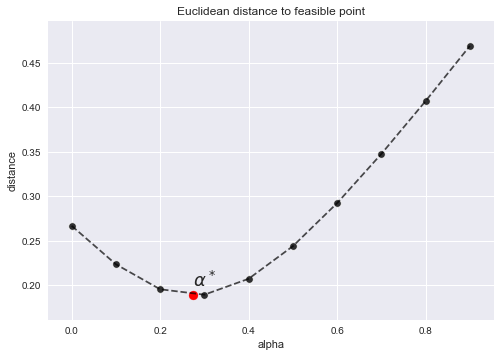

In [800]:
plt.style.use('seaborn')
plt.scatter(alpha_range, proj_dists[:-1], c='black', alpha=0.8, edgecolors='w', linewidth=1, s=60)
plt.scatter(alpha_opt, proj_dists[-1], c='red', s=80)
plt.text(alpha_opt, proj_dists[-1]+0.01, s=r'$\alpha^*$', size=18)
plt.plot(alpha_range, proj_dists[:-1], c='black', linestyle='--', alpha=0.7)
plt.title('Euclidean distance to feasible point')
plt.xlabel('alpha')
plt.ylabel('distance')
plt.show();

In [1301]:
import logging
logging.basicConfig(level=logging.INFO)
#logger = logging.getLogger(__name__)
def train_hsvm(w, X, y, C, num_epochs, lr, batch_size, early_stopping, verbose):
    init_w = w.copy()
    num_samples = len(y)
    early_stop_count = 0
    min_loss = np.inf
    best_w = init_w
    y = 2*y - 1
    if is_feasible(init_w):
        w_new = init_w
        for j in range(num_epochs):
            start = time.time()
            current_loss = 0
            shuffle_index = np.random.permutation(num_samples)
            for i in range(0, num_samples, batch_size):
                Xj = X[shuffle_index[i:i+batch_size]]
                yj = y[shuffle_index[i:i+batch_size]]
                grad_w = grad_fn(w, Xj, yj, C)
                w_new = w_new - lr*grad_w
                # if not in feasible region, need to use projection
                if not is_feasible(w_new):
                    # solve optimization problem for nearest feasible point
                    alpha_opt = alpha_search(w_new)
                    # project w to feasible sub-space
                    w_new = proj_boundary(w_new, alpha_opt)
                current_loss += loss_fn(w_new, Xj, yj, C)
            current_loss = current_loss / num_samples
            if current_loss < min_loss:
                min_loss = current_loss
                best_w = w_new
            else:
                early_stop_count += 1
                if early_stop_count >= early_stopping:
                    print('Exiting early: no decrease for ' + str(early_stopping) + ' rounds')
                    break
            if verbose:
                #logger.debug('loss {}'.format(sum_loss))
                print('COMPLETED EPOCH ', j+1)
                print('-------- LOSS: ', current_loss)
                #print('---------- total seconds: ', time.time() - start)
    else:
        print('Error: unable to begin training with initial w (weights)')
    return best_w

In [1366]:
centers = [[-0.4,-0.4], [-0.1, 0.3]]
X, labels = make_blobs(n_samples=5000, centers=centers, cluster_std=0.1)
svm = LinearSVC()
svm.fit(X, labels)
svm.classes_
svm.intercept_
svm.coef_
w1 = svm.coef_[0][0]
w2 = svm.coef_[0][1]
b = svm.intercept_
x = X[0]
w1*x[0] + w2*x[1] + b

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

array([0, 1])

array([0.84586157])

array([[2.14880574, 5.0576637 ]])

array([-2.22151493])

In [1367]:
svm.predict(X)[:5]
svm.decision_function(X)[:5]
mink_pts = poincare_pts_to_hyperboloid(X)
hsvm_clf = LinearHSVM(early_stopping=1, C=1, num_epochs=15, lr=0.0001, verbose=False)
hsvm_clf.fit(mink_pts, labels)
#hsvm_clf.coef_[0] = -hsvm_clf.coef_[0]
#w[0] = -w[0]

array([0, 0, 1, 1, 1])

array([-2.22151493, -3.11713839,  2.54690183,  2.30746921,  1.81077707])

In [1370]:
svm.predict(X)[:5]
svm.decision_function(X)[:5]
mink_pts = poincare_pts_to_hyperboloid(X)
hsvm_clf = LinearHSVM(early_stopping=1, C=1, num_epochs=30, lr=0.01, verbose=False)
hsvm_clf.fit(mink_pts, labels)
w = hsvm_clf.coef_
#w[0] = -w[0]
np.array([minkowski_dot(w, x) for x in mink_pts[:5]])
hsvm_clf.predict(mink_pts)[:10]

array([0, 0, 1, 1, 1])

array([-2.22151493, -3.11713839,  2.54690183,  2.30746921,  1.81077707])

Exiting early: no decrease for 1 rounds


array([ -8.37086476, -18.82341744,  16.94895771,  15.16146185,
        11.03166228])

array([0., 0., 1., 1., 1., 0., 1., 0., 0., 1.])

In [1371]:
svm.predict(X)[:10]
np.sum(hsvm_clf.predict(mink_pts) == svm.predict(X)) / len(labels)
np.sum(svm.predict(X) == labels) / len(labels)
np.sum(hsvm_clf.predict(mink_pts) == labels) / len(labels)

array([0, 0, 1, 1, 1, 0, 1, 0, 0, 1])

0.9988

0.9998

0.9986

In [1306]:
from sklearn.svm import LinearSVC

class LinearHSVM():
    """
    Hyperbolic support vector classification model trained in the hyperboloid (Lorentz) model 
    with an iterative, projected gradient descent method
    
    """
    
    def __init__(self, C=1.0, num_epochs=50, lr=0.001, tol=1e-8, batch_size=20, 
                 early_stopping=10, verbose=False):
        self.C = C
        self.num_epochs = num_epochs
        self.tol = tol
        self.verbose = verbose
        self.batch_size = batch_size
        self.early_stopping = early_stopping
        self.lr = lr
        
    def init_weights(self, X, y):
        """
        Initialize w (weights) with the coefficients found from applying
        standard LinearSVC in the ambient Euclidean space
        
        """
        # fit linear svm using scikit-learn classifier
        linear_svm = LinearSVC()
        linear_svm.fit(X, y)
        self.init_coef = linear_svm.coef_[0]
        # 
        #self.init_coef[0] = -linear_svm.coef_[0][0]
    
    def fit(self, X, y):
        """
        Train linear HSVM model for input data X, labels y
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples, 1)
        """
        self.init_weights(X, y)
        self.coef_ = train_hsvm(self.init_coef, X, y, self.C, 
                                self.num_epochs, self.lr, self.batch_size,
                                self.early_stopping, self.verbose)
        return self

    def predict(self, X):
        """
        Predict class labels with hyperbolic linear decision function
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        """
        y_pred = np.zeros((X.shape[0], ))
        vals = np.array([minkowski_dot(self.coef_, x) for x in X])
        y_pred[vals < 0] = 0
        y_pred[vals >= 0] = 1
        return y_pred
    
    def score(self, X, y):
        """
        Return mean accuracy evaluated on X, y
        """
        y_pred = self.predict(X)
        return np.sum(y_pred == y) / len(y)
    
#    def decision_function(self, X):
#        """
#        This function is used for ROC AUC
#        """
#        preds = htools.mink_prod(X, self.coef_).ravel()
#        return preds
    

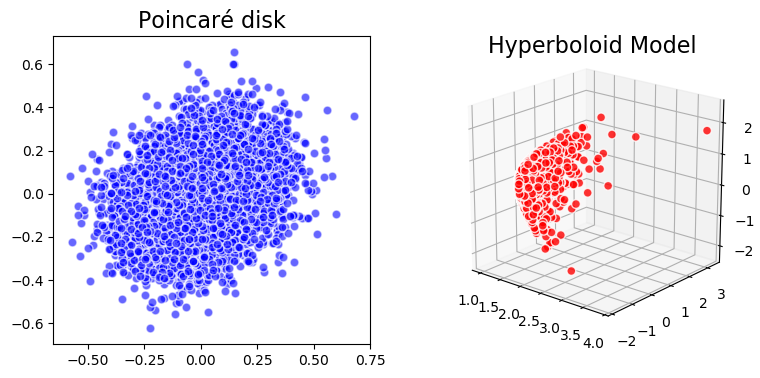

In [803]:
from sklearn.datasets import make_blobs
plt.style.use('default')
centers = [[-0.1,-0.1], [0.1, 0.1]]
X, labels = make_blobs(n_samples=5000, centers=centers, cluster_std=0.15)
data = X
mink_pts = poincare_pts_to_hyperboloid(data)
x = data[:, 0]
y = data[:, 1]

hyp_data = poincare_pts_to_hyperboloid(data)

fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)
ax.set_title('Poincaré disk', size=16)
ax.scatter(x, y, s=40, c='blue', edgecolor='white', linewidth=1, alpha=0.6);

ax = fig.add_subplot(122, projection = '3d')
ax.scatter(mink_pts[:, 0], mink_pts[:, 1], mink_pts[:, 2], c='red', 
           alpha=0.8, s=40, edgecolor='white', linewidth=1)
ax.set_title('Hyperboloid Model', size=16);
ax.view_init(20, -50);
plt.show();

[-0.14792307  1.38807716  1.44014508]
[-0.14846035  1.38384569  1.43582619]
[-0.14899763  1.37961421  1.43150731]
[-0.14953491  1.37538274  1.42718843]
[-0.15007219  1.37115126  1.42286955]
[-0.15060948  1.36691979  1.41855067]
[-0.15114676  1.36268831  1.41423179]
[-0.15168404  1.35845684  1.40991291]
[-0.15222132  1.35422536  1.40559403]
[-0.1527586   1.34999388  1.40127515]
[-0.15329588  1.34576241  1.39695626]
[-0.15383316  1.34153093  1.39263738]
[-0.15437045  1.33729946  1.3883185 ]
[-0.15490773  1.33306798  1.38399962]
[-0.15544501  1.32883651  1.37968074]
[-0.15598229  1.32460503  1.37536186]
[-0.15651957  1.32037356  1.37104298]
[-0.15705685  1.31614208  1.3667241 ]
[-0.15759413  1.31191061  1.36240521]
[-0.15813142  1.30767913  1.35808633]


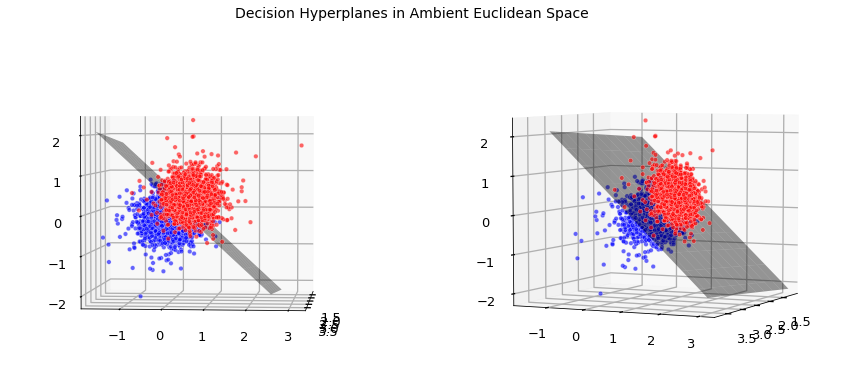

In [804]:
from sklearn.svm import LinearSVC
hsvm_clf = LinearHSVM(early_stopping=1, C=0.1, num_epochs=20, lr=0.00001, verbose=False)
hsvm_clf.fit(mink_pts, labels)
hsvm_clf.coef_
plt.style.use('seaborn-talk')
X = mink_pts
z = lambda x,y: (-hsvm_clf.coef_[0]*x-hsvm_clf.coef_[1]*y) / hsvm_clf.coef_[2]
x_range = np.linspace(0, 3, 20)
y_range = np.linspace(-1.8, 2.5, 20)
x,y = np.meshgrid(x_range, y_range)

%matplotlib inline
import matplotlib

fig = plt.figure(figsize=(15,6))
ax  = fig.add_subplot(121, projection='3d')
ax.set_xlim([np.min(X, axis=0)[0], np.max(X, axis=0)[0]])
ax.set_ylim([np.min(X, axis=0)[1], np.max(X, axis=0)[1]])
ax.set_zlim([np.min(X, axis=0)[2], np.max(X, axis=0)[2]])
ax.plot_surface(x, y, z(x,y), color='k', alpha=0.4, rstride=2, cstride=2, linewidth=.1)
ax.scatter(X[labels==0,0], X[labels==0,1], X[labels==0,2], c='blue', alpha=0.6, edgecolors='w')
ax.scatter(X[labels==1,0], X[labels==1,1], X[labels==1,2], c='red', alpha=0.6, edgecolors='w')
ax.view_init(3, 5)

ax  = fig.add_subplot(122, projection='3d')
ax.set_xlim([np.min(X, axis=0)[0], np.max(X, axis=0)[0]])
ax.set_ylim([np.min(X, axis=0)[1], np.max(X, axis=0)[1]])
ax.set_zlim([np.min(X, axis=0)[2], np.max(X, axis=0)[2]])
ax.plot_surface(x, y, z(x,y), color='k', alpha=0.4, rstride=2, cstride=2, linewidth=.1)
ax.scatter(X[labels==0,0], X[labels==0,1], X[labels==0,2], c='blue', alpha=0.6, edgecolors='w')
ax.scatter(X[labels==1,0], X[labels==1,1], X[labels==1,2], c='red', alpha=0.6, edgecolors='w')
ax.view_init(5, 25)
plt.suptitle(t='Decision Hyperplanes in Ambient Euclidean Space', size=14)
plt.show();

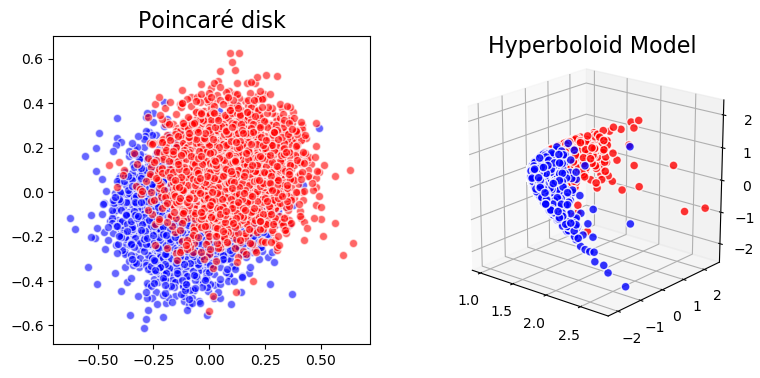

In [805]:
from sklearn.datasets import make_blobs
plt.style.use('default')
centers = [[-0.1,-0.1], [0.1, 0.1]]
X, labels = make_blobs(n_samples=5000, centers=centers, cluster_std=0.15)
data = X
mink_pts = poincare_pts_to_hyperboloid(data)
x = data[:, 0]
y = data[:, 1]

fig = plt.figure(figsize=(9,4))
ax = fig.add_subplot(121)
ax.set_title('Poincaré disk', size=16)
ax.scatter(X[labels==0,0], X[labels==0,1], c='blue', alpha=0.6, edgecolors='w')
ax.scatter(X[labels==1,0], X[labels==1,1], c='red', alpha=0.6, edgecolors='w')
ax = fig.add_subplot(122, projection = '3d')
ax.scatter(mink_pts[labels==0, 0], mink_pts[labels==0, 1], mink_pts[labels==0, 2], c='blue', 
           alpha=0.8, s=40, edgecolor='white', linewidth=1)
ax.scatter(mink_pts[labels==1, 0], mink_pts[labels==1, 1], mink_pts[labels==1, 2], c='red', 
           alpha=0.8, s=40, edgecolor='white', linewidth=1)
ax.set_title('Hyperboloid Model', size=16);
ax.view_init(20, -50);
plt.show();

[-0.15452758  1.32983646  1.34099771]
[-0.15509689  1.32575534  1.33690119]
[-0.15566619  1.32167423  1.33280467]
[-0.1562355   1.31759311  1.32870815]
[-0.1568048   1.313512    1.32461162]
[-0.15737411  1.30943088  1.3205151 ]
[-0.15794341  1.30534977  1.31641858]
[-0.15851272  1.30126865  1.31232206]
[-0.15908202  1.29718753  1.30822554]
[-0.15965133  1.29310642  1.30412901]
[-0.16022063  1.2890253   1.30003249]
[-0.16078994  1.28494419  1.29593597]
[-0.16135924  1.28086307  1.29183945]
[-0.16192855  1.27678196  1.28774292]
[-0.16249785  1.27270084  1.2836464 ]
[-0.16306716  1.26861973  1.27954988]
[-0.16363646  1.26453861  1.27545336]
[-0.16420577  1.26045749  1.27135684]
[-0.16477507  1.25637638  1.26726031]
[-0.16534438  1.25229526  1.26316379]


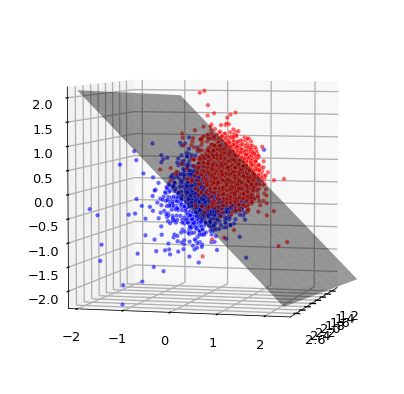

In [806]:
from sklearn.svm import LinearSVC
hsvm_clf = LinearHSVM(early_stopping=1, C=0.1, num_epochs=20, lr=0.00001, verbose=False)
hsvm_clf.fit(mink_pts, labels)
hsvm_clf.coef_
plt.style.use('seaborn-talk')
X = mink_pts
z = lambda x,y: (-hsvm_clf.coef_[0]*x-hsvm_clf.coef_[1]*y) / hsvm_clf.coef_[2]
x_range = np.linspace(0, 3, 20)
y_range = np.linspace(-1.8, 2.5, 20)
x,y = np.meshgrid(x_range, y_range)

%matplotlib inline
import matplotlib

fig = plt.figure(figsize=(7,7))
ax  = fig.add_subplot(111, projection='3d')
ax.set_xlim([np.min(X, axis=0)[0], np.max(X, axis=0)[0]])
ax.set_ylim([np.min(X, axis=0)[1], np.max(X, axis=0)[1]])
ax.set_zlim([np.min(X, axis=0)[2], np.max(X, axis=0)[2]])
ax.plot_surface(x, y, z(x,y), color='k', alpha=0.4, rstride=2, cstride=2, linewidth=.1)
ax.scatter(X[labels==0,0], X[labels==0,1], X[labels==0,2], c='blue', alpha=0.6, edgecolors='w')
ax.scatter(X[labels==1,0], X[labels==1,1], X[labels==1,2], c='red', alpha=0.6, edgecolors='w')
ax.view_init(5, 15);
plt.show();

In [889]:
centers = [[-0.41,-0.40], [-0.1, -0.1]]
X, labels = make_blobs(n_samples=5000, centers=centers, cluster_std=0.05)
data = X# / (np.max(norm(X, axis=1)) - 1e-3)
mink_pts = poincare_pts_to_hyperboloid(data)
hsvm_clf = LinearHSVM(early_stopping=1, C=1, num_epochs=i, lr=0.0001, verbose=False)
hsvm_clf.fit(mink_pts, labels)
w = hsvm_clf.coef_

In [884]:
scores = []
weights = []
for i in np.arange(0, 40, 2):
    hsvm_clf = LinearHSVM(early_stopping=1, C=1, num_epochs=i, lr=0.0001, verbose=False)
    hsvm_clf.fit(mink_pts, labels)
    w = hsvm_clf.coef_
    w[0] = -w[0]
    scores.append(hsvm_clf.score(mink_pts, labels))
    weights.append(hsvm_clf.coef_)

Exiting early: no decrease for 1 rounds


Exiting early: no decrease for 1 rounds


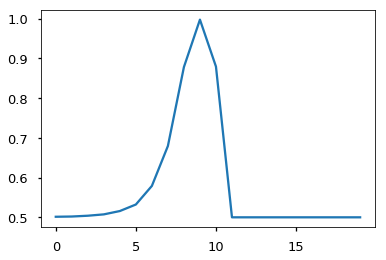

In [906]:
plt.plot(scores);

In [901]:
hsvm_clf = LinearHSVM(early_stopping=1, C=1, num_epochs=18, lr=0.0001, verbose=False)
hsvm_clf.fit(mink_pts, labels)
hsvm_clf.coef_
w = hsvm_clf.coef_
w[0] = -w[0]
hsvm_clf.coef_
L2 = poincare_pts_to_hyperboloid(np.random.randn(100000, 2))
inter = np.array([np.abs(minkowski_dot(x, w)) for x in L2]) < 1e-2
L2[inter].shape
hsvm_clf.score(mink_pts, labels)

array([0.46120912, 0.61589327, 0.44788542])

array([-0.46120912,  0.61589327,  0.44788542])

(667, 3)

1.0

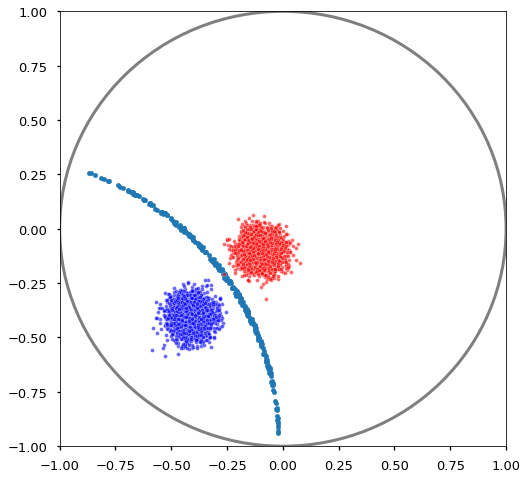

In [905]:
dec_bound = L2[inter]
ball_dec = hyperboloid_pts_to_poincare(dec_bound)
ball_dec = ball_dec[norm(ball_dec, axis=1) < 1]
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
plt.scatter(ball_dec[:, 0], ball_dec[:, 1], s=20)
plt.scatter(X[labels==0,0], X[labels==0,1], c='blue', alpha=0.6, edgecolors='w', s=15)
plt.scatter(X[labels==1,0], X[labels==1,1], c='red', alpha=0.6, edgecolors='w', s=15)
plt.xlim([-1.,1.])
plt.ylim([-1.,1.])
plt.show();

False


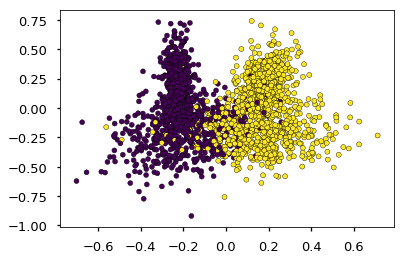

In [1187]:
from sklearn.datasets import make_moons, make_classification
X, labels = make_classification(n_features=2, n_redundant=0, n_informative=2, n_samples=2000, scale=.2, shift=-.1)
data = X
data[(norm(X, axis=1) > 1)] = data[(norm(X, axis=1) > 1)] / (np.max(norm(X, axis=1)))
print((norm(data, axis=1) > 1).any())
mink_pts = poincare_pts_to_hyperboloid(data)
plt.scatter(data[:, 0], data[:, 1], marker='o', c=labels, s=25, edgecolor='k');

In [1191]:
hsvm_clf = LinearHSVM(early_stopping=1, C=.1, num_epochs=30, lr=0.0001, verbose=False)
hsvm_clf.fit(mink_pts, labels)
w = hsvm_clf.coef_
w[0] = -w[0]
L2 = poincare_pts_to_hyperboloid(np.random.randn(100000, 2))
inter = np.array([np.abs(minkowski_dot(x, w)) for x in L2]) < 1e-2
L2[inter].shape
hsvm_clf.score(mink_pts, labels)

(264, 3)

0.8345

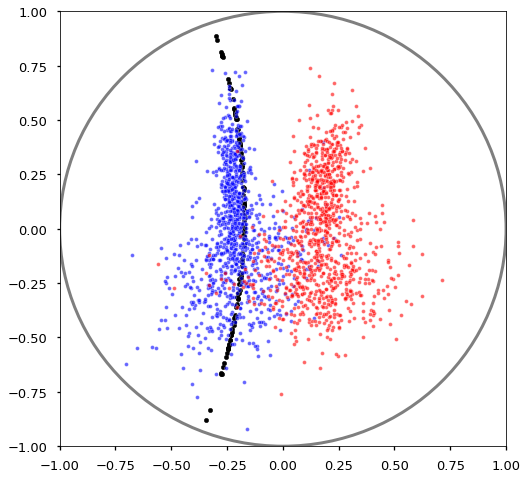

In [1193]:
dec_bound = L2[inter]
ball_dec = hyperboloid_pts_to_poincare(dec_bound)
ball_dec = ball_dec[norm(ball_dec, axis=1) < 1]
%matplotlib inline
fig = plt.figure(figsize=(8,8))
ax = plt.gca()
circ = plt.Circle((0, 0), radius=1, edgecolor='black', facecolor='None', linewidth=3, alpha=0.5)
ax.add_patch(circ)
X = data
plt.scatter(ball_dec[:, 0], ball_dec[:, 1], s=20, color='black')
plt.scatter(X[labels==0,0], X[labels==0,1], c='blue', alpha=0.6, edgecolors='w', s=15)
plt.scatter(X[labels==1,0], X[labels==1,1], c='red', alpha=0.6, edgecolors='w', s=15)
plt.xlim([-1.,1.])
plt.ylim([-1.,1.])
plt.show();